In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

ImportError: cannot import name 'model'

In [2]:
# 加载 CIFAR-10 数据集
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 数据归一化到 [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

In [3]:
class SEBlock(layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.reduction_ratio = reduction_ratio
    
    def build(self, input_shape):
        # 输入特征的通道数
        channel = input_shape[-1]
        
        # 全局平均池化
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        
        # 全连接层，用于生成通道权重
        self.dense1 = layers.Dense(channel // self.reduction_ratio, activation='relu', use_bias=False)
        self.dense2 = layers.Dense(channel, activation='sigmoid', use_bias=False)
    def call(self, inputs):
        # 计算通道注意力权重
        x = self.global_avg_pool(inputs)
        x = layers.Reshape((1, 1, -1))(x)  # Reshape为(batch, 1, 1, channels)
        
        x = self.dense1(x)
        x = self.dense2(x)
        
        # 对原始特征图进行加权
        return inputs * x

In [4]:
# Space Attention（空间注意力）
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        # 使用卷积生成空间注意力图
        self.conv = layers.Conv2D(1, (self.kernel_size, self.kernel_size), padding='same', activation='sigmoid')
    
    def call(self, inputs):
        # 对特征图进行卷积生成空间注意力图
        attention_map = self.conv(inputs)
        return inputs * attention_map

In [5]:
# 混合注意力模块：结合SE模块和空间注意力模块
class HybridAttention(layers.Layer):
    def __init__(self, reduction_ratio=16, kernel_size=7):
        super(HybridAttention, self).__init__()
        self.se_block = SEBlock(reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def call(self, inputs):
        # 先应用通道注意力
        x = self.se_block(inputs)
        # 然后应用空间注意力
        x = self.spatial_attention(x)
        return x

In [ ]:
# 构建模型并加入混合注意力机制
def build_cnn_with_hybrid_attention(input_shape=(32, 32, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        HybridAttention(),  # 添加混合注意力机制
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        HybridAttention(),  # 添加混合注意力机制
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        HybridAttention(),  # 添加混合注意力机制
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10分类（CIFAR-10）
    ])
    return model
model = build_cnn_with_hybrid_attention()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [10]:
# 编译模型
# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1563/1563 [==============================] - ETA: 0s - loss: 1.6989 - accuracy: 0.3724WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001F3EF8E8BF8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

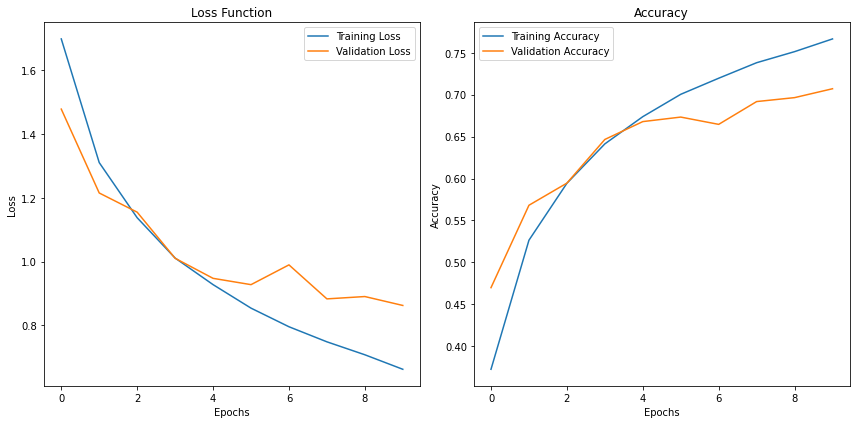

313/313 [==============================] - 2s 8ms/step - loss: 0.8627 - accuracy: 0.7071
Test accuracy: 0.707099974155426


In [11]:

# 训练模型并保存 history

# 训练模型
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
model.summary()

# 绘制损失函数和准确率曲线
plt.figure(figsize=(12, 6))

# 损失函数曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 评估模型并输出准确率
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

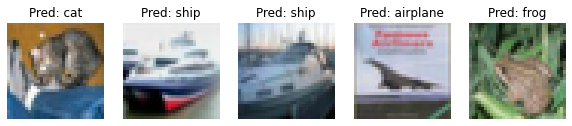

In [8]:
num_images = 5
predictions = model.predict(X_test[:num_images])
predicted_classes = np.argmax(predictions, axis=1)

# CIFAR-10 类别标签
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 显示图像与预测结果
plt.figure(figsize=(10, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Pred: {class_names[predicted_classes[i]]}")
    plt.axis('off')
plt.show()